In [2]:
import pandas as pd
import torch
import numpy as np
from mp_api.client import MPRester

with MPRester("3cc08jX8WHZOYwtfrU6KNl5urhUOy3xL") as mpr:
    docs = mpr.materials.summary.search(band_gap=(0.00001,None))

C:\Users\ramie\AppData\Local\Temp\ipykernel_7940\1846863495.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


No module named 'phonopy'
No module named 'phonopy'


Retrieving SummaryDoc documents:   0%|          | 0/81004 [00:00<?, ?it/s]

c:\Users\ramie\AppData\Local\Programs\Python\Python311\Lib\site-packages\mp_api\client\core\client.py:829: UserWarning: Use the 'fields' argument to select only fields of interest to speed up data retrieval for large queries. Choose from: ['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total

In [3]:
mean_atomic_numbers = []
max_atomic_numbers = []
min_atomic_numbers = []
std_atomic_numbers = []

a_parameters = []
b_parameters = []
c_parameters = []
alpha_parameters = []
beta_parameters = []
gamma_parameters = []

mean_distance_matrix = []
max_distance_matrix = []
min_distance_matrix = []
std_distance_matrix = []

band_gaps = []

input = []

In [4]:
for i in range(len(docs)):
    
    mean_atomic_numbers += [np.mean(docs[i].structure.atomic_numbers)]
    max_atomic_numbers += [np.max(docs[i].structure.atomic_numbers)]
    min_atomic_numbers += [np.min(docs[i].structure.atomic_numbers)]
    std_atomic_numbers += [np.std(docs[i].structure.atomic_numbers)]

    # Lattice parameters:
    a_parameters += [docs[i].structure.lattice.abc[0]]
    b_parameters += [docs[i].structure.lattice.abc[1]]
    c_parameters += [docs[i].structure.lattice.abc[2]]
    alpha_parameters += [docs[i].structure.lattice.angles[0]]
    beta_parameters += [docs[i].structure.lattice.angles[1]]
    gamma_parameters += [docs[i].structure.lattice.angles[2]]

    mean_distance_matrix += [np.mean(docs[i].structure.distance_matrix)]
    max_distance_matrix += [np.max(docs[i].structure.distance_matrix)]
    min_distance_matrix += [np.min(docs[i].structure.distance_matrix)]
    std_distance_matrix += [np.std(docs[i].structure.distance_matrix)]

    band_gaps.append([docs[i].band_gap])
    input.append([mean_atomic_numbers[i],max_atomic_numbers[i],min_atomic_numbers[i],std_atomic_numbers[i],a_parameters[i],b_parameters[i],c_parameters[i],alpha_parameters[i],beta_parameters[i],gamma_parameters[i],mean_distance_matrix[i],max_distance_matrix[i],min_distance_matrix[i],std_distance_matrix[i]])



In [5]:
#Converting the input into something the thing can read

input = torch.tensor(input, dtype = torch.float32)
band_gaps = torch.tensor(band_gaps, dtype = torch.float32)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(14, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [32]:
import random

small_input =[]
small_band_gaps =[]
inputlist = input.tolist()
band_gapslist = band_gaps.tolist()
for i in range(100):
    random_i = random.randint(0,len(docs))
    small_input.append(inputlist[i])
    small_band_gaps.append(band_gapslist[i])

small_input = torch.tensor(small_input)
small_band_gaps = torch.tensor(small_band_gaps)


In [38]:
#Train on gpu and splitting up the data to training, validation and testing.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_temp, y_train, y_temp = train_test_split(input,band_gaps, test_size=0.3, random_state=64)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=64)

Epoch [100/1000], Train Loss: 1.9987, Val Loss: 1.9462, Train MSE: 1.9987, Val MSE: 1.9462, Train MAE: 1.1271, Val MAE: 1.1148, Train R2: 0.0591, Val R2: 0.0802
Epoch [200/1000], Train Loss: 2.1968, Val Loss: 2.1412, Train MSE: 2.1968, Val MSE: 2.1412, Train MAE: 1.2026, Val MAE: 1.1907, Train R2: -0.0604, Val R2: -0.0371
Epoch [300/1000], Train Loss: 2.0065, Val Loss: 1.9655, Train MSE: 2.0065, Val MSE: 1.9655, Train MAE: 1.1403, Val MAE: 1.1309, Train R2: 0.0541, Val R2: 0.0644
Epoch [400/1000], Train Loss: 1.9533, Val Loss: 1.9150, Train MSE: 1.9533, Val MSE: 1.9150, Train MAE: 1.1180, Val MAE: 1.1107, Train R2: 0.0989, Val R2: 0.1081
Epoch [500/1000], Train Loss: 1.9504, Val Loss: 1.9160, Train MSE: 1.9504, Val MSE: 1.9160, Train MAE: 1.1033, Val MAE: 1.0957, Train R2: 0.1064, Val R2: 0.1094
Epoch [600/1000], Train Loss: 2.0049, Val Loss: 1.9579, Train MSE: 2.0049, Val MSE: 1.9579, Train MAE: 1.1262, Val MAE: 1.1159, Train R2: 0.0577, Val R2: 0.0720
Epoch [700/1000], Train Loss: 1.

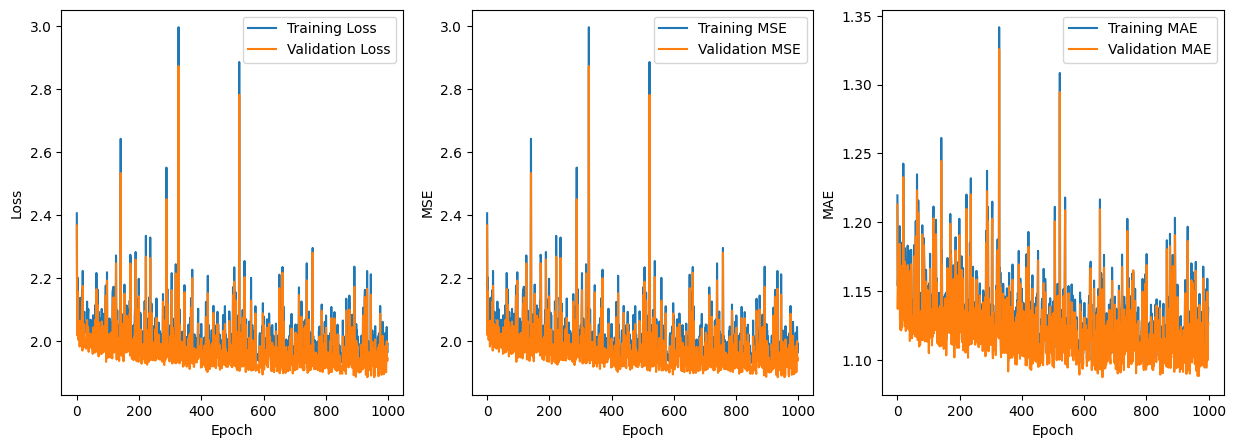

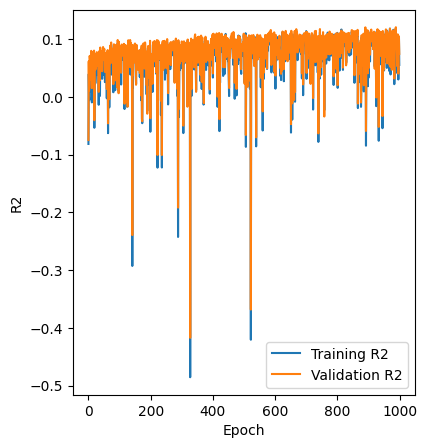

In [39]:
model = RegressionNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train_losses = []
val_losses = []

# Lists to store training and validation MSEs and MAEs for plotting
train_mses = []
val_mses = []
train_maes = []
val_maes = []

train_r2s = []
val_r2s = []

# Training the model
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        train_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        train_r2 = 0.0
        total_train = 0

        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device).float(), train_labels.to(device).float()
            train_outputs = model(train_inputs)
            train_loss += criterion(train_outputs, train_labels).item()
            train_mse += nn.functional.mse_loss(train_outputs, train_labels).item()
            train_mae += nn.functional.l1_loss(train_outputs, train_labels).item()
            train_r2 += r2_score(train_labels.cpu().numpy(), train_outputs.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_mse = train_mse / len(train_loader)
        avg_train_mae = train_mae / len(train_loader)
        avg_train_r2 = train_r2 / len(train_loader)

        val_loss = 0.0
        val_mse = 0.0
        val_mae = 0.0
        val_r2 = 0.0
        total_val = 0

        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device).float(), val_labels.to(device).float()
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_labels).item()
            val_mse += nn.functional.mse_loss(val_outputs, val_labels).item()
            val_mae += nn.functional.l1_loss(val_outputs, val_labels).item()
            val_r2 += r2_score(val_labels.cpu().numpy(), val_outputs.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_mse = val_mse / len(val_loader)
        avg_val_mae = val_mae / len(val_loader)
        avg_val_r2 = val_r2 / len(val_loader)

    # Append losses and metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_mses.append(avg_train_mse)
    val_mses.append(avg_val_mse)
    train_maes.append(avg_train_mae)
    val_maes.append(avg_val_mae)
    train_r2s.append(avg_train_r2)
    val_r2s.append(avg_val_r2)

    # Print the training and validation statistics every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train MSE: {avg_train_mse:.4f}, Val MSE: {avg_val_mse:.4f}, Train MAE: {avg_train_mae:.4f}, Val MAE: {avg_val_mae:.4f}, Train R2: {avg_train_r2:.4f}, Val R2: {avg_val_r2:.4f}')

# Plotting the training and validation loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation MSE curves
plt.subplot(1, 3, 2)
plt.plot(train_mses, label='Training MSE')
plt.plot(val_mses, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plotting the training and validation MAE curves
plt.subplot(1, 3, 3)
plt.plot(train_maes, label='Training MAE')
plt.plot(val_maes, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plotting the training and validation R2 curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(train_r2s, label='Training R2')
plt.plot(val_r2s, label='Validation R2')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

In [56]:
print("This is the [a,b,c] parameters:", docs[0].structure.lattice.abc)
print("This is [alpha,beta,gamma] parameters", docs[0].structure.lattice.angles)
print("This is the distance matrix: \n", docs[0].structure.distance_matrix)
print("This is the atomic numbers of all the atoms:", docs[0].structure.atomic_numbers)

This is the [a,b,c] parameters: (4.61294, 4.61294, 13.991829)
This is [alpha,beta,gamma] parameters (90.0, 90.0, 90.0)
This is the distance matrix: 
 [[0.         4.47265604 6.69441857 2.82475439 2.23632802]
 [4.47265604 0.         2.82475439 6.69441857 2.23632802]
 [6.69441857 2.82475439 0.         3.86966418 5.06108241]
 [2.82475439 6.69441857 3.86966418 0.         5.06108241]
 [2.23632802 2.23632802 5.06108241 5.06108241 0.        ]]
This is the atomic numbers of all the atoms: (89, 89, 35, 35, 8)


In [2]:
print("fix")

fix
